In [183]:
#qtip
from qutip import *

#general DS tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
from IPython.display import Markdown as md
from IPython.display import display
%matplotlib inline

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
cancer_data = load_breast_cancer()


#tf/keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

In [186]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))


def activation(x):
    return sigmoid(x)


def activation_prime(x):
    return sigmoid_prime(x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))


def activation(x):
    return sigmoid(x)


def activation_prime(x):
    return sigmoid_prime(x)


def mad(predict, target):
    '''
        Mean Absolute Deviation
    '''
    #print(target.data)
    return sum(abs(predict - target)) / target.data.shape[0]


def score_model(predictions, target):
    return {
        'accuracy': accuracy_score(np.real(predictions), np.real(target)),
        'mae': mean_absolute_error(np.real(predictions), np.real(target))
    }


def train_test_split_nn(features, target):
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        stratify=[np.real(x)
                  for x in target.data],  #make sure we stratify properly
        random_state=random_state,
        train_size=0.8,
        test_size=0.2)
    return Qobj(X_train), Qobj(X_test), Qobj(y_train), Qobj(y_test)


def qtip_nnet(features,
              target,
              features_test=None,
              target_test=None,
              random_state=random_state,
              bias=0.5,
              learning_rate=0.10,
              iterations=10000,
              verbose=False,
              brake_callback=None):
    np.random.seed(random_state)
    weights = np.array([[x] for x in np.random.random((features.dims[1][0]))])
    results = []
    for epoch in range(iterations):
        inputs = Qobj(features)
        in_o = inputs * Qobj(weights) + bias
        out_o = Qobj(activation(in_o))
        loss = out_o - Qobj(target)
        if verbose:
            print(loss)
        
        derror_douto = loss
        douto_dino = Qobj(activation_prime(out_o))
        deriv = derror_douto
        for r, c in enumerate(deriv):  #does this do a hadamard product?
            deriv.data[r] *= douto_dino.data[r]

        inputs = inputs.trans()
        deriv_final = inputs * deriv
        weights -= learning_rate * deriv_final

        for i in deriv:
            bias -= learning_rate * i

        epoch_results = {
            f'weight_{i}': weight[0][0]
            for i, weight in enumerate(weights)
        }

        epoch_results.update({
            'epoch': epoch,
            'bias': bias[0][0],
        })
        predict_test = predict_nnet(epoch_results, features_test)
        test_scoring = score_model(predict_test, target_test)
        epoch_results.update(test_scoring)
        print(
            f'Epoch:{epoch} Test Acc: {test_scoring["accuracy"]:.6f} Test MAE: {test_scoring["mae"]:.6f}',
            end='\r')

        #check for brake callback
        if epoch >= brake_callback.patience:
            all_scores = {
                'accuracy': [x['accuracy'] for x in results],
                'mae': [x['mae'] for x in results]
            }  #TODO: throw these in a separate dict to reduce overhead, also make more abstract instead of hc scores
            if not brake_callback.should_continue(all_scores):
                display(md(f'***Early Stoppage***'))
                display(md(f'- Epoch: *{epoch}*'))
                display(md(f'- Last Value: *{brake_callback.last_val:.6f}*'))
                display(md(f'- Test Value: *{brake_callback.compare_to:.6f}*'))
                display(md(f'- Function: *{brake_callback.func}*'))
                display(md(f'- Score: *{brake_callback.stat}*'))
                display(md(f'- Criterion: *{brake_callback.compare_type}*'))
                display(md(f'- Tolerance: *{brake_callback.tolerance:.6f}*'))
                epoch_results.update({'brake_callback': brake_callback})
                break
            else:
                epoch_results.update({'brake_callback': None})

        results.append(epoch_results)
    return results


def plot_nnet(nnet_results, feature_names, score='accuracy'):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
    weight_plots = []
    for i, feature in enumerate(feature_names):
        p = sns.lineplot(x=[x['epoch'] for x in nnet_results],
                         y=[np.real(x[f'weight_{i}']) for x in nnet_results],
                         ax=ax[0],
                         label=f'{feature_names[i]}')
        weight_plots.append(p)
    p3 = sns.lineplot(x=[x['epoch'] for x in nnet_results],
                      y=[np.real(x['bias']) for x in nnet_results],
                      c='green',
                      ax=ax[1])
    p4 = sns.lineplot(x=[x['epoch'] for x in nnet_results][1:],
                      y=[np.real(x[score]) for x in nnet_results][1:],
                      c='orange',
                      ax=ax[2])
    weight_plots.append(p3)
    weight_plots.append(p4)
    for f in weight_plots:
        f.set_xlabel('Epoch')
        f.set_xticklabels([f'{x:,.0f}' for x in f.get_xticks()])
        f.set_yticklabels([f'{y:,.3f}' for y in f.get_yticks()])

    p3.set_title('Bias by Epoch')
    p4.set_title(f'{score} by Epoch')


def predict_nnet(model, test, cutoff=0.5):
    weights = Qobj(np.array([y for x, y in model.items() if 'weight' in x]))
    bias = model['bias']
    return Qobj([[softmax(activation(test[i][0].T * weights + bias), cutoff)]
                 for i in range(0, test.shape[0])])


def softmax(val, cutoff):
    return 1 if val >= cutoff else 0


class BrakeCondition:
    def __init__(self,
                 stat='accuracy',
                 patience=5,
                 tolerance=0.005,
                 compare_type='better',
                 func=None):
        self.stat = stat  #'accuracy or mae'
        self.patience = patience
        self.func = func  #a func to be applied to brake - np.mean, np.median etc?
        self.tolerance = tolerance
        self.compare_type = compare_type

    #TODO: add more rolling-type brakes?
    def should_continue(self, scores):
        check = scores[self.stat]
        self.last_val = check[-1]
        #compare_to = check[-self.patience]
        if self.func:
            self.compare_to = self.func(
                check[-self.patience:-2]
            )  #compare to function inclusive or exclusive of last element?
        else:  #compare to raw value some steps in past
            self.compare_to = check[-self.patience]
        if self.compare_type == 'better':
            return False if (
                self.last_val - self.compare_to
            ) < self.tolerance else True  #stats are getting higher/better (Accuracy, R-squared etc)
        else:
            return False if (
                self.last_val - self.compare_to
            ) > self.tolerance else True  #stats are getting lower/better (RMSE, MAE)


def weight_report(models, feature_names=cancer_data['feature_names']):
    #feature_names = cancer_data['feature_names']
    #models = nets
    report = []
    for j, feature in enumerate(feature_names):
        #print(feature)
        all_weights = []
        for i, (random_state, model) in enumerate(models.items()):
            #gather all the values this weight across models/epochs
            #model_weights = [y for x, y in model.items() if f'weight_{j}' in x]
            model_weights = []
            for m in model:
                #get each value by epoch
                [
                    model_weights.append(np.real(y + m['bias']))
                    for x, y in m.items() if x == f'weight_{j}'
                ]
            report.append({
                'feature': feature,
                'random_state': random_state,
                'mean': np.mean(model_weights),
                'median': np.median(model_weights),
                'max': np.max(model_weights),
                'min': np.min(model_weights),
                'std': np.std(model_weights)
            })
            #print(random_state, len(model_weights))
        #print(report)
        #break
        #all_weights.extend(model_weights)
    report = pd.DataFrame(report).set_index(['feature'])

    fig, ax = plt.subplots(nrows=len(feature_names),
                           ncols=1,
                           figsize=(20, 120),
                           sharex=True)
    ax.ravel()
    for i, (feature, data) in enumerate(report.groupby(lambda x: x)):
        #print(feature)
        sns.scatterplot(x=data['random_state'],
                        y=data['mean'],
                        ax=ax[i],
                        label='mean')
        sns.scatterplot(x=data['random_state'],
                        y=data['max'],
                        ax=ax[i],
                        label='max')
        sns.scatterplot(x=data['random_state'],
                        y=data['min'],
                        ax=ax[i],
                        label='min')
        sns.scatterplot(x=data['random_state'],
                        y=data['median'],
                        ax=ax[i],
                        label='median')
        sns.lineplot(x=data['random_state'],
                     y=[np.mean(data['mean'])] * len(data['random_state']),
                     ax=ax[i],
                     label='total_avg')

        ax[i].set_ylabel(f'${feature.upper()}$')
        ax[i].lines[0].set_linestyle('dotted')

    plt.tight_layout()

    return report

In [187]:
scaler = StandardScaler()
raw_data = cancer_data['data']
#xform the data again later, this is just for test
data_xform = scaler.fit_transform(cancer_data['data'])

In [3]:
random_state = 5

In [4]:
data = Qobj(data_xform)
data

Quantum object: dims = [[569], [30]], shape = (569, 30), type = oper, isherm = False
Qobj data =
[[ 1.09706398 -2.07333501  1.26993369 ...  2.29607613  2.75062224
   1.93701461]
 [ 1.82982061 -0.35363241  1.68595471 ...  1.0870843  -0.24388967
   0.28118999]
 [ 1.57988811  0.45618695  1.56650313 ...  1.95500035  1.152255
   0.20139121]
 ...
 [ 0.70228425  2.0455738   0.67267578 ...  0.41406869 -1.10454895
  -0.31840916]
 [ 1.83834103  2.33645719  1.98252415 ...  2.28998549  1.91908301
   2.21963528]
 [-1.80840125  1.22179204 -1.81438851 ... -1.74506282 -0.04813821
  -0.75120669]]

In [6]:
target = Qobj(cancer_data['target'])
target

Quantum object: dims = [[569], [1]], shape = (569, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [7]:
len(cancer_data['feature_names'])

30

## TODO:

- Set stopping criterion
- Train/Test split on cancer set
- Test randomization of weights
- Test random bias
- add layers
- make predictions

### Perform train test split, check class balance, then normalize

#### Train Test Split:

Keep it simple, 80/20 first - add cross validation later

In [8]:
X_train, X_test, y_train, y_test = train_test_split_nn(features=raw_data, target=target)

#### Class Balance:

In [9]:
y_train.data.sum()/y_train.data.shape[0]

(0.6263736263736264+0j)

In [10]:
y_test.data.sum()/y_test.data.shape[0]

(0.631578947368421+0j)

In [11]:
train_scaler = StandardScaler()
X_train = Qobj(train_scaler.fit_transform(np.real(X_train)))
X_test = Qobj(train_scaler.transform(np.real(X_test)))

In [12]:
assert X_train.data.shape[0] == y_train.data.shape[0]

In [140]:
model_train = qtip_nnet(features=Qobj(X_train),
                        target=y_train,
                        features_test=X_test,
                        target_test=y_test,
                        random_state=5,
                        brake_callback=BrakeCondition(tolerance=0.005,
                                                      compare_type='better',
                                                      func=np.mean,
                                                      patience=500))

***Early Stoppage***

- Epoch: *500*

- Last Value: *0.973684*

- Test Value: *0.971958*

- Function: *<function mean at 0x0000027054AF3F28>*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

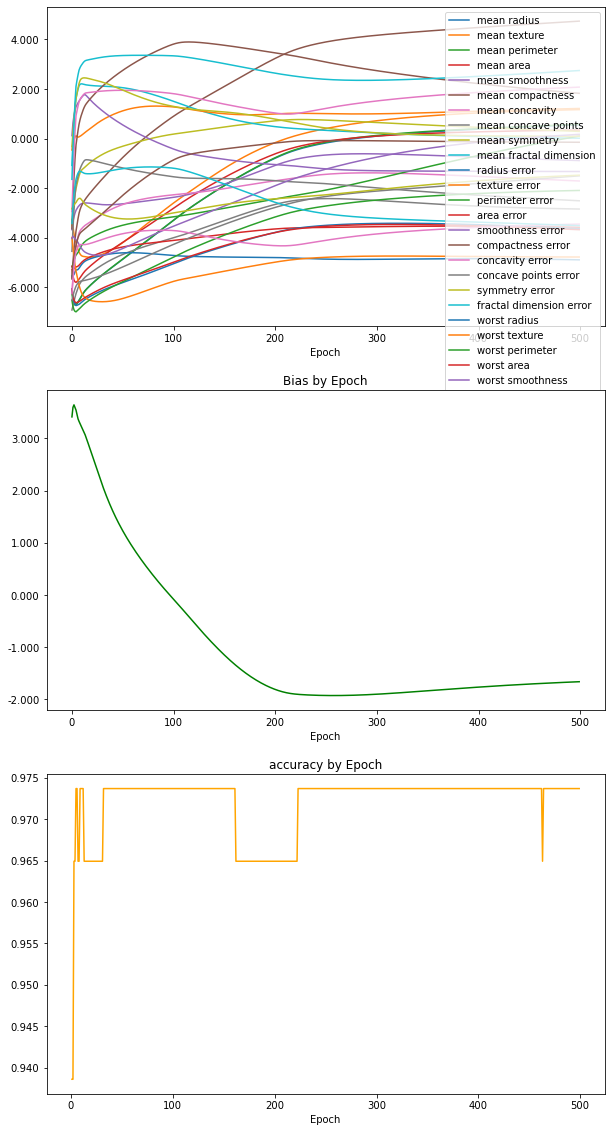

In [141]:
plot_nnet(model_train, cancer_data['feature_names'])

In [15]:
nets = {}
for random_state in range(0, 6):
    nets.update({
        random_state:
        qtip_nnet(features=Qobj(X_train),
                  target=y_train,
                  random_state=random_state,
                  features_test=X_test,
                  target_test=y_test,
                  brake_callback=BrakeCondition(tolerance=0.005, patience=20))
    })

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.964912*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *24*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *23*

- Last Value: *0.964912*

- Test Value: *0.964912*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *23*

- Last Value: *0.964912*

- Test Value: *0.964912*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

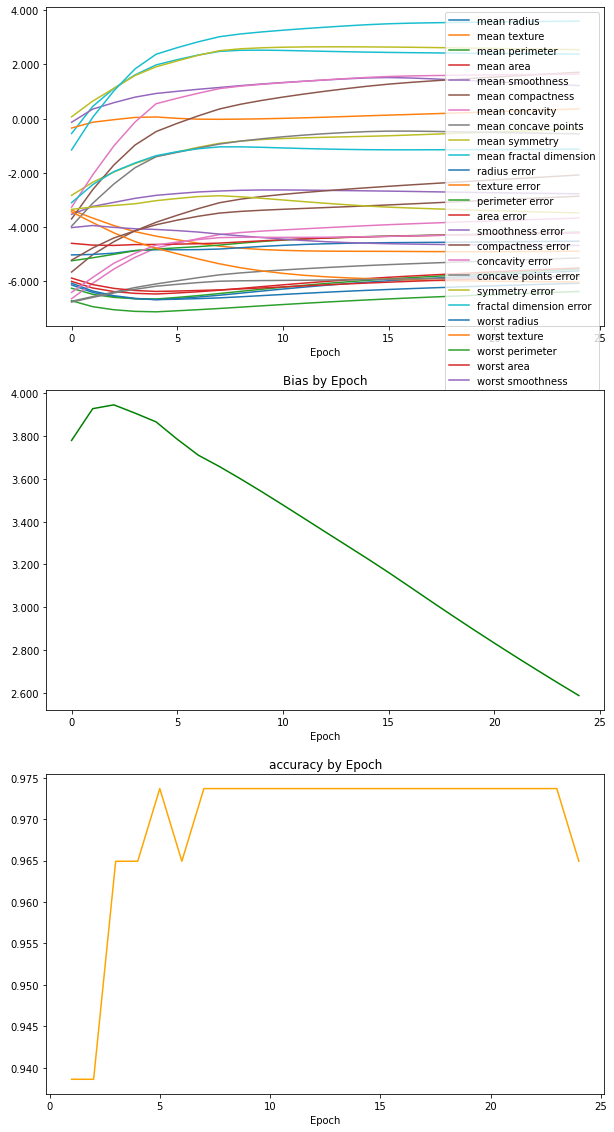

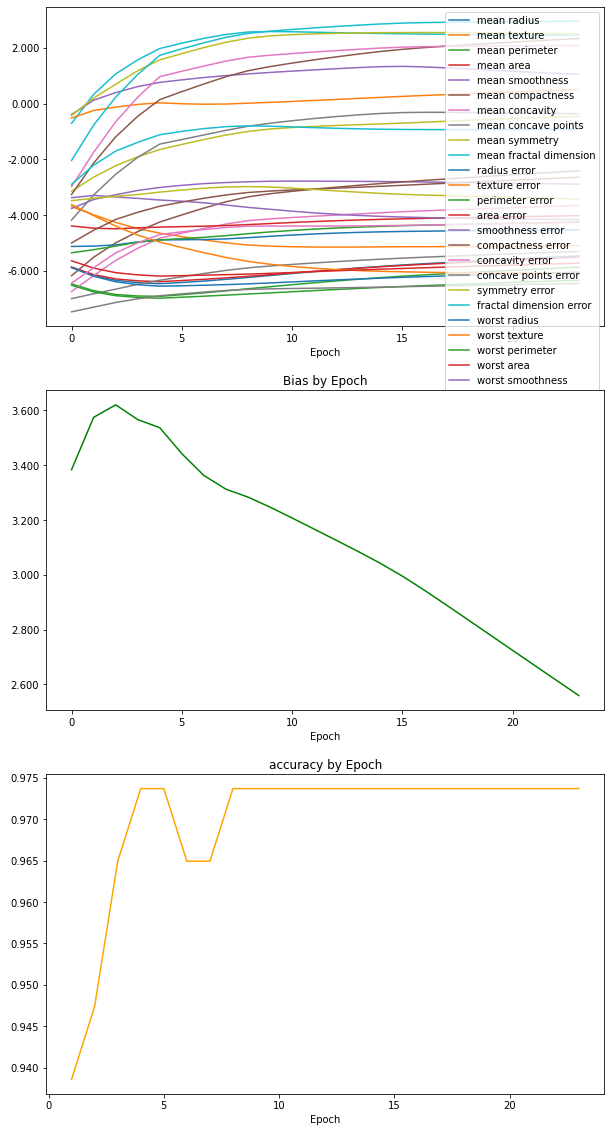

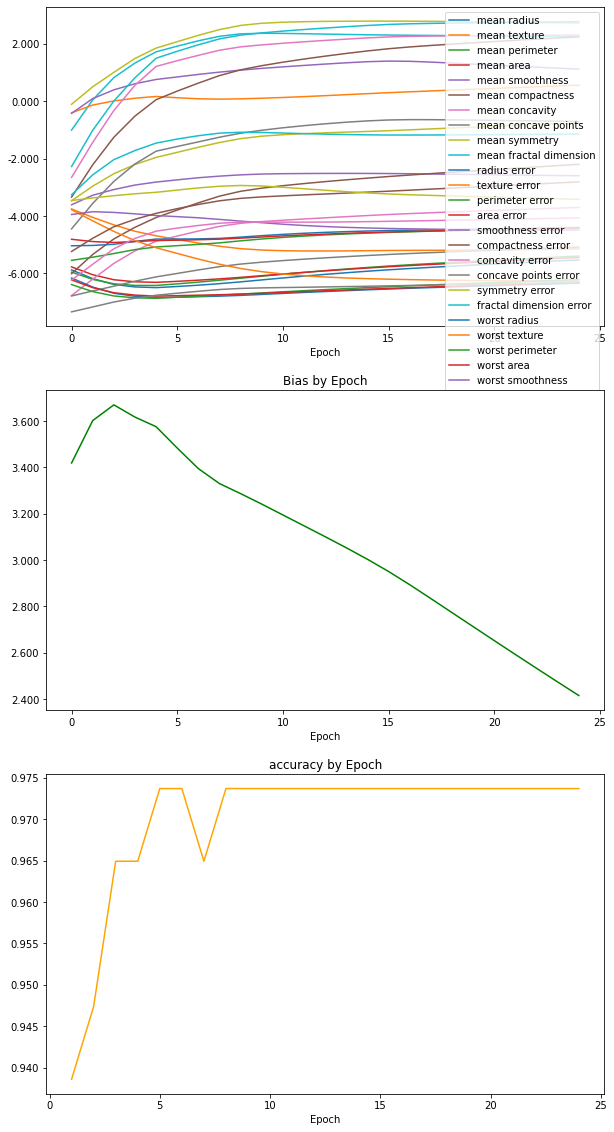

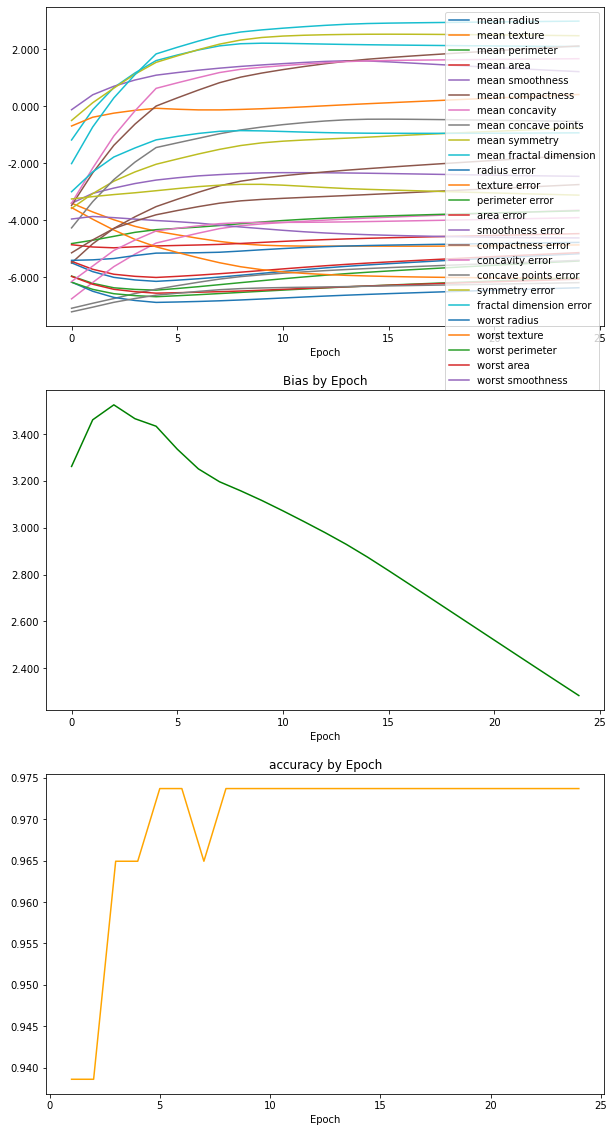

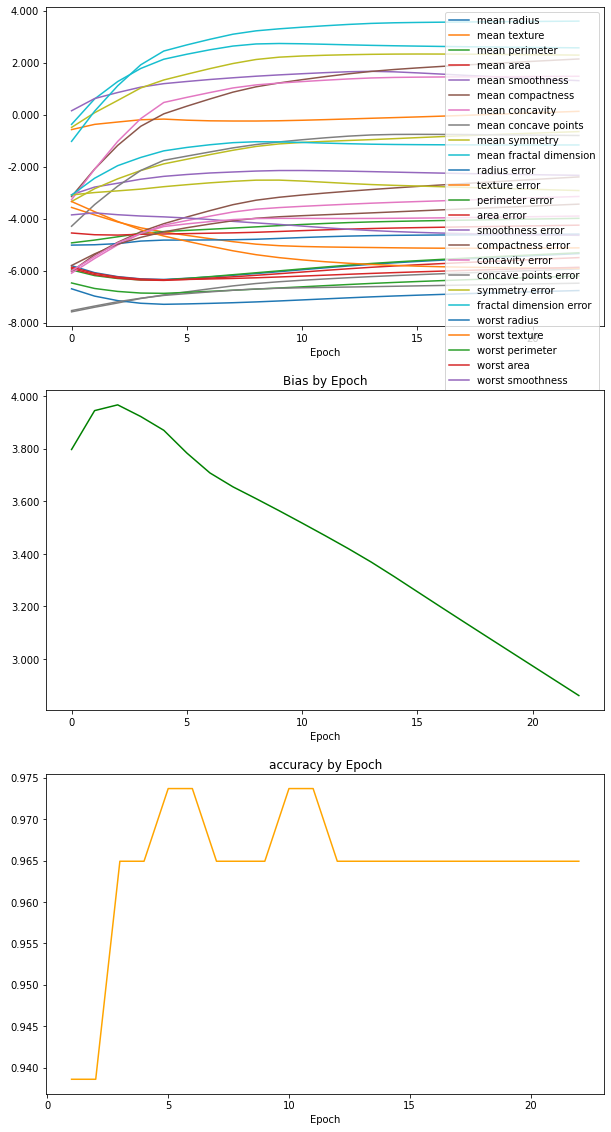

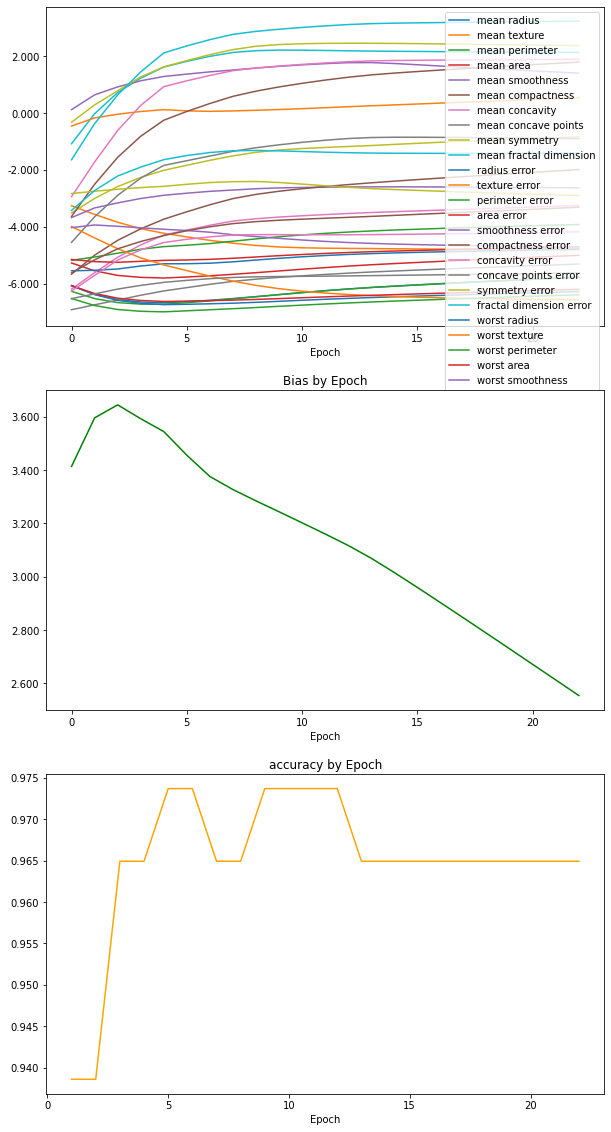

In [344]:
for rs, model in nets.items():
    plot_nnet(model, cancer_data['feature_names'])

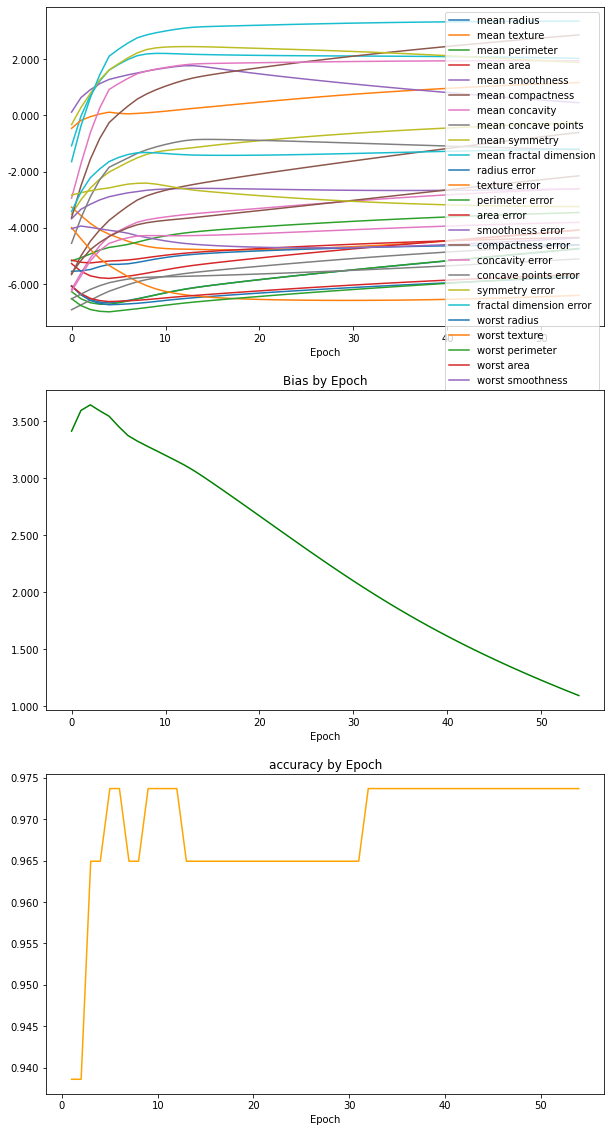

In [345]:
plot_nnet(model_train, cancer_data['feature_names'])

### Weight Report

In theory, a good model will have consistent weights across different random initializations - let's test that theory out by running the same model multiple times with different random seeds.

In [16]:
nets = {}
for random_state in range(0, 10):
    nets.update({
        random_state:
        qtip_nnet(features=Qobj(X_train),
                  target=y_train,
                  random_state=random_state,
                  features_test=X_test,
                  target_test=y_test,
                  brake_callback=BrakeCondition(tolerance=0.005, patience=20))
    })

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.964912*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *24*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *23*

- Last Value: *0.964912*

- Test Value: *0.964912*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *23*

- Last Value: *0.964912*

- Test Value: *0.964912*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *23*

- Last Value: *0.964912*

- Test Value: *0.964912*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *23*

- Last Value: *0.964912*

- Test Value: *0.964912*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

***Early Stoppage***

- Epoch: *25*

- Last Value: *0.973684*

- Test Value: *0.973684*

- Function: *None*

- Score: *accuracy*

- Criterion: *better*

- Tolerance: *0.005000*

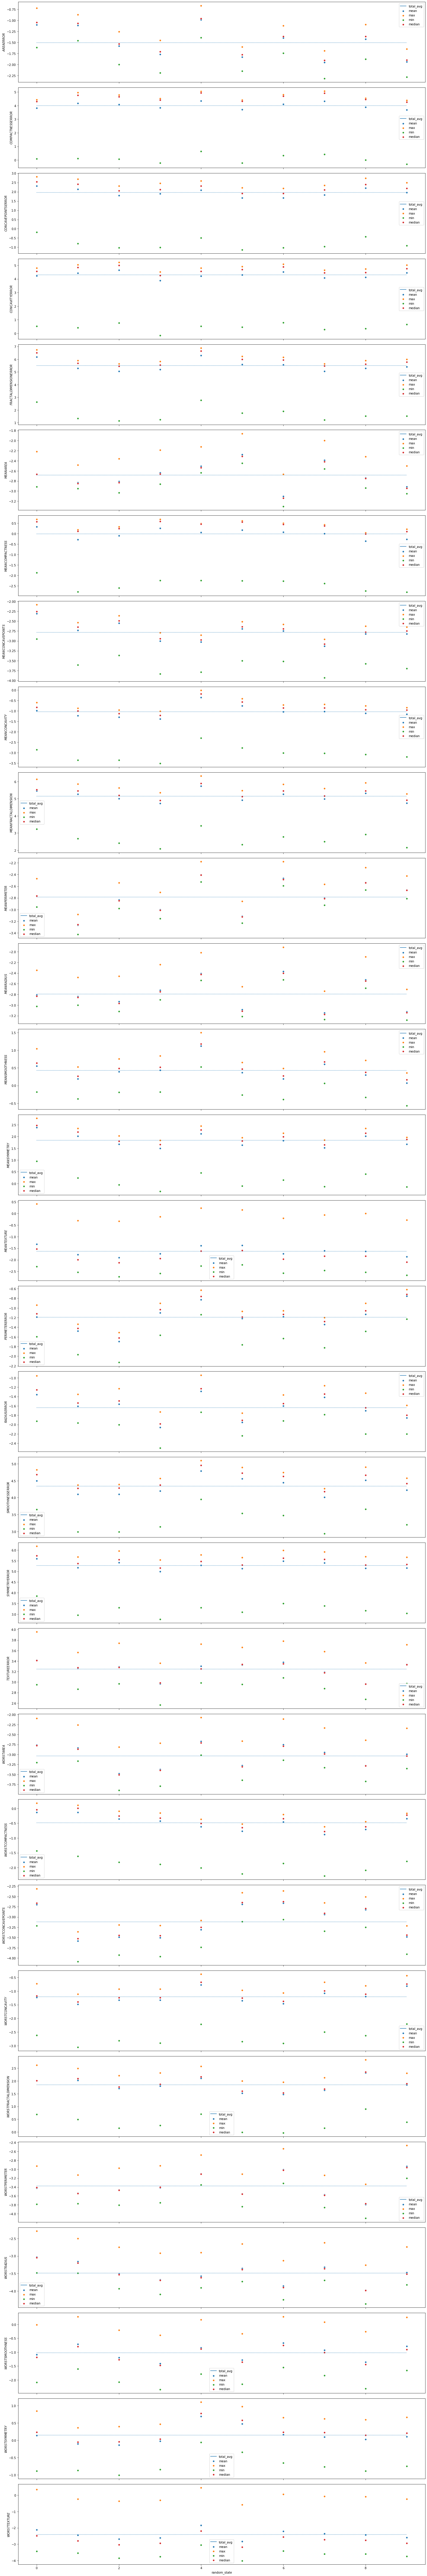

In [188]:
report = weight_report(nets)

In [20]:
base_activation = 'relu'
seq = tf.keras.Sequential(
    [
        #tf.keras.layers.InputLayer(use_bias=True),
        #tf.keras.layers.Dense(30, activation=base_activation),
        #tf.keras.layers.Dropout(rate=0.5),
        #tf.keras.layers.Dense(300, activation=base_activation),
        #tf.keras.layers.Dense(300, activation=base_activation),
        #tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        tf.keras.layers.Softmax()
    ]
)

In [21]:
seq.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])

In [23]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

seq.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
print("done.")

# early stopping callback
es = EarlyStopping(monitor="accuracy", min_delta=0.001, patience=10)

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    cancer_data['data'],
    cancer_data['target'],
    random_state=random_state,
    train_size=0.8,
    test_size=0.2)
history = seq.fit(X_train_tf,
                  y_train_tf,
                  validation_data=(X_test_tf, y_test_tf),
                  callbacks=[es],
                  epochs=10000)

done.
Epoch 1/10000
15/15 [==============================] - 0s 13ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy: 0.6491
Epoch 2/10000
15/15 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy: 0.6491
Epoch 3/10000
15/15 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy: 0.6491
Epoch 4/10000
15/15 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy: 0.6491
Epoch 5/10000
15/15 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy: 0.6491
Epoch 6/10000
15/15 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy: 0.6491
Epoch 7/10000
15/15 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.6220 - val_loss: 0.3509 - val_accuracy:

In [42]:
model_tf = {f'weight_{i}': x[0] for i, x in enumerate(seq.weights[0].numpy())}

In [45]:
model_tf['bias'] = seq.weights[1].numpy()[0]

In [46]:
model_tf

{'weight_0': -0.31157452,
 'weight_1': 0.30565178,
 'weight_2': 0.1719386,
 'weight_3': -0.21714157,
 'weight_4': 0.09413725,
 'weight_5': 0.37219024,
 'weight_6': 0.34889436,
 'weight_7': 0.4253804,
 'weight_8': -0.37045243,
 'weight_9': -0.32713896,
 'weight_10': 0.19184309,
 'weight_11': 0.07953006,
 'weight_12': 0.23384482,
 'weight_13': 0.26505655,
 'weight_14': 0.25117087,
 'weight_15': -0.35233557,
 'weight_16': 0.07122272,
 'weight_17': 0.25225967,
 'weight_18': -0.4022755,
 'weight_19': -0.26720944,
 'weight_20': -0.3024965,
 'weight_21': -0.41895303,
 'weight_22': -0.17838255,
 'weight_23': -0.030138522,
 'weight_24': 0.19201809,
 'weight_25': 0.037308395,
 'weight_26': 0.15120238,
 'weight_27': 0.19212997,
 'weight_28': -0.2521494,
 'weight_29': -0.12403715,
 'bias': 0.0}

In [68]:
tf_predict = predict_nnet(model_tf, Qobj(X_test_tf))

In [69]:
tf_predict

Quantum object: dims = [[114], [1]], shape = (114, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [70]:
score_model(tf_predict, y_test_tf)

{'accuracy': 0.3508771929824561, 'mae': 0.6491228070175439}

In [71]:
lg = LogisticRegression(random_state=random_state).fit(X_train_tf, y_train_tf)

In [72]:
preds = lg.predict(X_test_tf)

In [73]:
score_model(preds, y_test_tf)

{'accuracy': 0.9385964912280702, 'mae': 0.06140350877192982}

In [115]:
scaled_lg = lg.coef_[0]/abs(lg.coef_[0]).max()

In [167]:
lg_rank= pd.DataFrame([{
    'field': x,
    'Param LG': y,
    'Importance LG': abs(y)
} for x, y in zip(list(cancer_data['feature_names']), scaled_lg)
              ]).sort_values(['Importance LG'], ascending=False).reset_index(
                  drop=True).reset_index().rename(columns={'index': 'lg_rank'})

In [92]:
rf = RandomForestClassifier(random_state=random_state).fit(X_train_tf, y_train_tf)
pred_rf = rf.predict(X_test_tf)
score_model(pred_rf, y_test_tf)

{'accuracy': 0.956140350877193, 'mae': 0.043859649122807015}

In [156]:
rf_rank = pd.DataFrame([{
    'field': x,
    'RF Importance': y
} for x, y in zip(list(cancer_data['feature_names']), rf.feature_importances_)
              ]).sort_values(['RF Importance'], ascending=False).reset_index(
                  drop=True).reset_index().rename(columns={'index': 'rf_rank'})

In [133]:
best_model  = model_train[5]

In [134]:
best_weights = [y for x, y in best_model.items() if 'weight' in x]
best_weights = best_weights/max([abs(x) for x in best_weights])
{x:np.real(y) for x,y in zip(cancer_data['feature_names'], best_weights)}

{'mean radius': -0.9540661102775801,
 'mean texture': -0.6265024310916498,
 'mean perimeter': -0.9591191897204726,
 'mean area': -0.829218531869599,
 'mean smoothness': -0.405463750390946,
 'mean compactness': -0.49928914504482197,
 'mean concavity': -0.5917716862104929,
 'mean concave points': -0.8827802220576216,
 'mean symmetry': -0.2643845970997284,
 'mean fractal dimension': 0.2610485931320332,
 'radius error': -0.7619904752844383,
 'texture error': 0.010854722054916884,
 'perimeter error': -0.6684263683778677,
 'area error': -0.743091913375971,
 'smoothness error': 0.19651486145450883,
 'compactness error': 0.007829918954006108,
 'concavity error': 0.1627376958405655,
 'concave points error': -0.24119553701523339,
 'symmetry error': 0.2647888300415677,
 'fractal dimension error': 0.33914448025759447,
 'worst radius': -0.9671279836480392,
 'worst texture': -0.7968802343483302,
 'worst perimeter': -0.9999999999999999,
 'worst area': -0.9509369363044343,
 'worst smoothness': -0.5942

In [164]:
qt_rank = pd.DataFrame([{
    'field': x,
    'Param Q-tip': np.real(y),
    'Importance Q-tip': abs(np.real(y))
} for x, y in zip(cancer_data['feature_names'], best_weights)]).sort_values(
    ['Importance Q-tip'], ascending=False).reset_index(
        drop=True).reset_index().rename(columns={'index': 'qt_rank'})

In [138]:
pred_qt = predict_nnet(best_model, X_test)

In [139]:
score_model(pred_qt, y_test)

{'accuracy': 0.9736842105263158, 'mae': 0.02631578947368421}

In [142]:
tf_weights = [y for x, y in model_tf.items() if 'weight' in x]
tf_weights = tf_weights/max([abs(x) for x in tf_weights])
{x:np.real(y) for x,y in zip(cancer_data['feature_names'], tf_weights)}

{'mean radius': -0.7324609,
 'mean texture': 0.7185375,
 'mean perimeter': 0.40419963,
 'mean area': -0.51046443,
 'mean smoothness': 0.22130133,
 'mean compactness': 0.8749586,
 'mean concavity': 0.82019377,
 'mean concave points': 1.0,
 'mean symmetry': -0.8708733,
 'mean fractal dimension': -0.76905036,
 'radius error': 0.45099184,
 'texture error': 0.1869622,
 'perimeter error': 0.549731,
 'area error': 0.62310475,
 'smoothness error': 0.5904618,
 'compactness error': -0.8282835,
 'concavity error': 0.16743301,
 'concave points error': 0.5930214,
 'symmetry error': -0.94568413,
 'fractal dimension error': -0.62816584,
 'worst radius': -0.71111995,
 'worst texture': -0.9848903,
 'worst perimeter': -0.4193483,
 'worst area': -0.07085075,
 'worst smoothness': 0.45140323,
 'worst compactness': 0.087705955,
 'worst concavity': 0.35545215,
 'worst concave points': 0.45166624,
 'worst symmetry': -0.5927622,
 'worst fractal dimension': -0.2915911}

In [158]:
tf_rank = pd.DataFrame([{
    'field': x,
    'Param TF': y,
    'Importance TF': abs(y)
} for x, y in zip(cancer_data['feature_names'], tf_weights)]).sort_values(
    ['Importance TF'], ascending=False).reset_index(
        drop=True).reset_index().rename(columns={'index': 'tf_rank'})

In [178]:
pd.concat([
    qt_rank.set_index('field'),
    lg_rank.set_index('field'),
    rf_rank.set_index('field'),
    tf_rank.set_index('field')
],
          axis=1)[['qt_rank', 'lg_rank', 'rf_rank', 'tf_rank']].sort_values(
              ['qt_rank']) + 1

,qt_rank,lg_rank,rf_rank,tf_rank
worst perimeter,1,5,1,22
worst radius,2,1,4,11
mean perimeter,3,7,11,23
mean radius,4,2,6,9
worst area,5,28,5,30
mean concave points,6,14,3,1
worst concave points,7,11,2,19
mean area,8,24,8,18
worst texture,9,6,12,2
radius error,10,22,16,21


In [182]:
train_scaler = StandardScaler()
X_train = Qobj(train_scaler.fit_transform(np.real(X_train)))
X_test = Qobj(train_scaler.transform(np.real(X_test)))

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'target_names': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'images': array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
         [ 0.,  0., 13., ..., 15.,  5.,  0.],
         [ 0.,  3., 15., ..., 11.,  8.,  0.],
         ...,
         [ 0.,  4., 11., ..., 12.,  7.,  0.],
         [ 0.,  2., 14., ..., 12.,  0.,  0.],
         [ 0.,  0.,  6., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
         [ 0.,  0.,  0., ...,  9.,  0.,  0.],
         [ 0.,  0.,  3., ...,  6.,  0.,  0.],
         ...,
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  1., ...,  6.,  0.,  0.],
         [ 0.,  0.,  0., ..., 10.,  0.,  0.]],
 
        [[ 0